<a href="https://colab.research.google.com/github/thiru2024/GNN-prediction/blob/main/Tt_lvl_company_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##importing Libraries

In [5]:
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from time import time
import pandas as pd
import torch
import torch.nn as nn


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Exploratory Data Analysis

# train data

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

data = pd.read_excel('/content/gdrive/MyDrive/intern_tasks/Text-Classification-using-GNN-main/Training_Data(1).xlsx')
print(data.shape)
data.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
(6045, 3)


,Company Name,Business Description,Industry Classification Tag
0,"ADSOUTH PARTNERS, INC.","Adsouth Partners, Inc. provides advertising ag...",Advertising
1,"Artec Global Media, Inc.","Artec Global Media, Inc., formerly Artec Consu...",Advertising
2,Betawave Corp.,Betawave Corporation provides online marketing...,Advertising
3,BOSTON OMAHA Corp,Boston Omaha Corporation is engaged in the bus...,Advertising
4,Bright Mountain Media Inc,"Bright Mountain Media, Inc. is a digital media...",Advertising


In [8]:
data.isnull().sum()

Company Name                    0
Business Description           23
Industry Classification Tag     0
dtype: int64

In [9]:
data[data["Business Description"].isnull() == True]

,Company Name,Business Description,Industry Classification Tag
630,Heritage Global Inc.,NaN,Asset Management & Custody Banks
1254,Contagious Gaming Inc.,NaN,Casinos & Gaming
2243,Cardinal Resources Ltd.,NaN,Gold
2247,Carlin Gold Corporation,NaN,Gold
2256,Condor Gold plc,NaN,Gold
2288,Fortune Bay Corp.,NaN,Gold
2312,Gold Reserve Inc. Class A,NaN,Gold
2327,Hansa Resources Limited,NaN,Gold
2384,McEwen Mining Inc.,NaN,Gold
2423,Patriot Gold Corp.,NaN,Gold


In [10]:
data['Business Description'] = np.where(data["Business Description"].isnull() == True,data["Company Name"],data["Business Description"])
data.isnull().sum()

Company Name                   0
Business Description           0
Industry Classification Tag    0
dtype: int64

In [11]:
data.drop_duplicates(keep=False,inplace=True)

In [12]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 6044
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Company Name                 5943 non-null   object
 1   Business Description         5943 non-null   object
 2   Industry Classification Tag  5943 non-null   object
dtypes: object(3)
memory usage: 185.7+ KB


,Company Name,Business Description,Industry Classification Tag
count,5943,5943,5943
unique,5941,5938,62
top,Heritage Global Inc.,Timberline Resources Corporation is engaged in...,Regional Banks
freq,2,2,569


In [13]:
data["Business Description"].str.len().describe()

count    5943.000000
mean      850.619552
std       205.122038
min        11.000000
25%       797.000000
50%       944.000000
75%       986.000000
max      1325.000000
Name: Business Description, dtype: float64

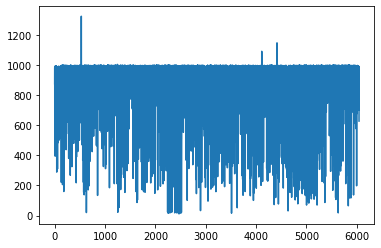

In [14]:
data["Business Description"].str.len().plot()

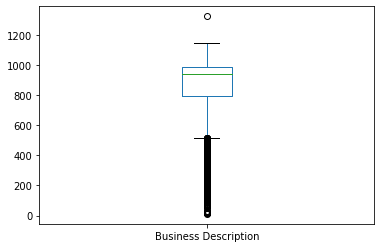

In [15]:
data["Business Description"].str.len().plot.box()

In [16]:
classes = {i:typ for i,typ in enumerate(data.iloc[:,2].unique())}

In [17]:
data.iloc[:,1] = data.iloc[:,1].str.lower()
data.iloc[:,2] = data.iloc[:,2].str.lower()
data.columns = data.columns.str.strip()
data.columns = data.columns.str.lower()

In [18]:
data.drop('company name',1,inplace=True)

In [19]:
dum = data['industry classification tag']
data.drop(columns='industry classification tag',inplace=True)
data = pd.concat([dum,data],axis=1)
data.head()

,industry classification tag,business description
0,advertising,"adsouth partners, inc. provides advertising ag..."
1,advertising,"artec global media, inc., formerly artec consu..."
2,advertising,betawave corporation provides online marketing...
3,advertising,boston omaha corporation is engaged in the bus...
4,advertising,"bright mountain media, inc. is a digital media..."


In [20]:
data.columns = ['','']
data.head()

,,
0,advertising,"adsouth partners, inc. provides advertising ag..."
1,advertising,"artec global media, inc., formerly artec consu..."
2,advertising,betawave corporation provides online marketing...
3,advertising,boston omaha corporation is engaged in the bus...
4,advertising,"bright mountain media, inc. is a digital media..."


In [21]:
train = data

In [22]:
data = pd.read_excel('/content/gdrive/MyDrive/intern_tasks/Text-Classification-using-GNN-main/Training_Data(1).xlsx')
data.shape

(6045, 3)

In [23]:
data.iloc[:,0] = data.iloc[:,0].str.lower()

In [24]:
test = data

In [25]:
train.to_csv('/content/gdrive/MyDrive/intern_tasks/Text-Classification-using-GNN-main/Training_Data(1).xlsx',index=False)
test.to_csv('/content/gdrive/MyDrive/intern_tasks/Text-Classification-using-GNN-main/Training_Data(1).xlsx',index=False)

# Tokenizer and embedding matrix from pretrained embeddings

In [26]:
class Tokenizer:
  def __init__(self, pretrained_file):
    self.pretrained_file = pretrained_file
    self.str_to_int = dict() #for fast lookups
    self.int_to_str = dict()

    self.padding = '#pad#'
    self.rand_str = '#rand#'
    self.embedding_matrix = list()

    #preparing embedding matrix
    with open(pretrained_file,'r', encoding='utf8') as f:
      for i, line in enumerate(f):
        values = line.split()
        self.str_to_int[values[0]] = i
        self.int_to_str[i] = values[0]
        self.embedding_matrix.append([float(v) for v in values[1:]])
    i += 1
    self.str_to_int[self.rand_str] = i
    self.int_to_str[i] = self.rand_str
    self.embedding_matrix.append(np.random.rand(len(self.embedding_matrix[0])))

    i += 1
    self.str_to_int[self.padding] = i
    self.int_to_str[i] = self.padding
    self.embedding_matrix.append(np.zeros(len(self.embedding_matrix[0])))

    self.embedding_matrix = np.array(self.embedding_matrix).astype(np.float32)

  def encode(self, sentence):
    if len(sentence): list(sentence)
    else: sentence = sentence.split(" ")

    encoded_sentence = list()
    for word in sentence:
      encoded_sentence.append(self.str_to_int.get(word,self.str_to_int[self.rand_str]))
    return encoded_sentence

  def decode(self,en_sentence):
    if type(en_sentence) == list:
      sentence = list()
      for en_word in en_sentence:
        sentence.append(self.int_to_str[en_word])
      return senetnce

  def embedding(self, en_sentence):
    return self.embedding_matrix[np.array(en_sentence)]


In [34]:
tokenizer = Tokenizer('/content/gdrive/MyDrive/intern_tasks/Text-Classification-using-GNN-main/glove.6B.300d.txt',)
#from keras.preprocessing.text import Tokenizer
#MAX_NB_WORDS = 2000
#tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)

In [28]:
'''import pandas as pd
from pandas import read_excel
data['Business Description'] = data['Business Description'].astype(str)
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
data["x"] = ord_enc.fit_transform(data[["Industry Classification Tag"]])
data=data.drop(['Industry Classification Tag','Company Name'], axis = 1)
plt.hist(data['x'])
train_text, test_text, train_y, test_y = train_test_split(data['Business Description'],data['x'],test_size = 0.2)
train_text.shape
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
sequences[0]'''

'import pandas as pd\nfrom pandas import read_excel\ndata[\'Business Description\'] = data[\'Business Description\'].astype(str)\nfrom sklearn.preprocessing import OrdinalEncoder\nord_enc = OrdinalEncoder()\ndata["x"] = ord_enc.fit_transform(data[["Industry Classification Tag"]])\ndata=data.drop([\'Industry Classification Tag\',\'Company Name\'], axis = 1)\nplt.hist(data[\'x\'])\ntrain_text, test_text, train_y, test_y = train_test_split(data[\'Business Description\'],data[\'x\'],test_size = 0.2)\ntrain_text.shape\nMAX_NB_WORDS = 20000\n\n# get the raw text data\ntexts_train = train_text.astype(str)\ntexts_test = test_text.astype(str)\n\n# finally, vectorize the text samples into a 2D integer tensor\ntokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)\ntokenizer.fit_on_texts(texts_train)\nsequences = tokenizer.texts_to_sequences(texts_train)\nsequences_test = tokenizer.texts_to_sequences(texts_test)\n\nword_index = tokenizer.word_index\nprint(\'Found %s unique tokens.\' % len

# Preparing Train, Validation and Test Data Loaders

In [35]:
def create_neighbor_set(node_set, p=3):
  sequence_length = len(node_set)
  neighbor_set = []
  for i in range(sequence_length):
      neighbor = []
      for j in range(-p, p+1):
          if 0 <= i + j < sequence_length:
              neighbor.append(node_set[i+j])
      neighbor_set.append(neighbor)
  return neighbor_set

In [36]:
class GNN_Dataset(Dataset):
    def __init__(self, node_sets, neighbor_sets, public_edge_mask, labels):
      super(GNN_Dataset).__init__()
      self.node_sets = node_sets
      self.neighbor_sets = neighbor_sets
      self.public_edge_mask = public_edge_mask
      self.labels = labels

    def __getitem__(self, i):
      if self.labels:
        return torch.LongTensor(self.node_sets[i]), \
              torch.nn.utils.rnn.pad_sequence([torch.LongTensor(neighbor) for neighbor in self.neighbor_sets[i]], batch_first=True, padding_value=1), \
              self.public_edge_mask[torch.LongTensor(self.node_sets[i]).unsqueeze(-1).repeat(1, torch.nn.utils.rnn.pad_sequence([torch.LongTensor(neighbor) for neighbor in self.neighbor_sets[i]], batch_first=True, padding_value=1).shape[-1]), \
                                    torch.nn.utils.rnn.pad_sequence([torch.LongTensor(neighbor) for neighbor in self.neighbor_sets[i]], batch_first=True, padding_value=1)], \
              torch.FloatTensor(self.labels[i])
      else:
        return torch.LongTensor(self.node_sets[i]), \
              torch.nn.utils.rnn.pad_sequence([torch.LongTensor(neighbor) for neighbor in self.neighbor_sets[i]], batch_first=True, padding_value=1), \
              self.public_edge_mask[torch.LongTensor(self.node_sets[i]).unsqueeze(-1).repeat(1, torch.nn.utils.rnn.pad_sequence([torch.LongTensor(neighbor) for neighbor in self.neighbor_sets[i]], batch_first=True, padding_value=1).shape[-1]), \
                                    torch.nn.utils.rnn.pad_sequence([torch.LongTensor(neighbor) for neighbor in self.neighbor_sets[i]], batch_first=True, padding_value=1)]


    def __len__(self):
      return len(self.node_sets)

In [41]:
class GNN_Dataset_class:
  def __init__(self, train_filename, test_filename, tokenizer, MAX_LENGTH=70, p=3, min_freq=2, train_validation_split=0.5):
    self.train_filename = train_filename
    self.test_filename = test_filename
    self.tokenizer = tokenizer
    self.MAX_LENGTH = MAX_LENGTH
    self.p = p
    self.min_freq = min_freq
    self.train_validation_split = train_validation_split

    self.train_data = pd.read_csv(self.train_filename, header=None)
    self.train_data.dropna(0,inplace=True)
    self.test_data = pd.read_csv(self.test_filename, header=None)
    self.test_data.dropna(0,inplace=True)

    self.str_to_int = {'#rand#': 0, '#pad#': 1} 
    self.int_to_str = {0: '#rand#', 1: '#pad#'}
    self.vocab_count = len(self.str_to_int)
    self.embedding_matrix = None
    self.label_dict = dict(zip(self.train_data[0].unique(), pd.get_dummies(self.train_data[0].unique()).values.tolist()))

    self.train_dataset, self.validation_dataset = random_split(self.train_data.to_numpy(), [int(len(self.train_data) * train_validation_split), len(self.train_data) - int(len(self.train_data) * train_validation_split)])
    self.test_dataset = self.test_data.to_numpy()

    self.build_vocab()

    self.train_dataset, self.validation_dataset, self.test_dataset, self.edge_stat, self.public_edge_mask = self.prepare_dataset()

  def build_vocab(self):
    scrap = ["."]
    #,\
    #        "'","`","''","\"","“"," ","'m","'no","***","--","...","[","]","{","}","~","@","#","$","%","^","*","/","<",">","+","-","="]
    vocab_list = [sentence.split(' ') for _, sentence in self.train_dataset]
    unique_vocab = [] 
    for vocab in vocab_list:
      if vocab not in scrap: unique_vocab.extend(vocab)
    unique_vocab = list(set(unique_vocab))
    for vocab in unique_vocab:
      if vocab in self.tokenizer.str_to_int.keys():
        self.str_to_int[vocab] = self.vocab_count
        self.int_to_str[self.vocab_count] = vocab
        self.vocab_count += 1
    self.embedding_matrix = self.tokenizer.embedding(self.tokenizer.encode(list(self.str_to_int.keys())))

  def prepare_dataset(self):
    node_sets = [[self.str_to_int.get(vocab, 0) for vocab in sentence.strip().split(' ')][:self.MAX_LENGTH] for _, sentence in self.train_dataset] 
    neighbor_sets = [create_neighbor_set(node_set, p=self.p) for node_set in node_sets]
    labels = [self.label_dict[label] for label, _ in self.train_dataset]

    edge_stat, public_edge_mask = self.build_public_edge_mask(node_sets, neighbor_sets, min_freq=self.min_freq)

    train_dataset = GNN_Dataset(node_sets, neighbor_sets, public_edge_mask, labels)

    node_sets = [[self.str_to_int.get(vocab, 0) for vocab in sentence.strip().split(' ')][:self.MAX_LENGTH] for _, sentence in self.validation_dataset]
    neighbor_sets = [create_neighbor_set(node_set, p=self.p) for node_set in node_sets]
    labels = [self.label_dict[label] for label, _ in self.validation_dataset]
    validation_dataset = GNN_Dataset(node_sets, neighbor_sets, public_edge_mask, labels)

    node_sets = [[self.str_to_int.get(vocab, 0) for vocab in sentence.item().strip().split(' ')][:self.MAX_LENGTH] for sentence in self.test_dataset]
    neighbor_sets = [create_neighbor_set(node_set, p=self.p) for node_set in node_sets]
    test_dataset = GNN_Dataset(node_sets, neighbor_sets, public_edge_mask, labels=None)

    return train_dataset, validation_dataset, test_dataset, edge_stat, public_edge_mask

  def build_public_edge_mask(self, node_sets, neighbor_sets, min_freq=2):
    edge_stat = torch.zeros(self.vocab_count, self.vocab_count)
    for node_set, neighbor_set in zip(node_sets, neighbor_sets):
      for neighbor in neighbor_set:
        for to_node in neighbor:
          edge_stat[node_set, to_node] += 1
    public_edge_mask = edge_stat < min_freq
    return edge_stat, public_edge_mask
  

In [76]:
# libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
np.random.seed(32)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.utils.np_utils import to_categorical


%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(data["Business Description"])
vectorizer.vocabulary_
vectorizer.transform(data["Business Description"]).toarray()
from sklearn.model_selection import train_test_split


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 32726 unique tokens.


[4348,
 634,
 14,
 6,
 34,
 4,
 2409,
 634,
 5,
 37,
 4,
 165,
 29,
 28,
 475,
 594,
 2261,
 16,
 2,
 1702,
 3,
 1436,
 1176,
 2,
 18,
 4,
 2409,
 402,
 87,
 2,
 4348,
 11957,
 83,
 1002,
 11958,
 39,
 9,
 1177,
 2675,
 1121,
 2806,
 1,
 17335,
 39,
 9,
 2338,
 2148,
 11959,
 381,
 4031,
 20,
 5730,
 3799,
 846,
 2807,
 52,
 4349,
 395,
 31,
 1348,
 52,
 11960,
 9,
 7,
 2262,
 2148,
 15,
 3800,
 1,
 5731,
 2806,
 508,
 55,
 7,
 335,
 594,
 2676,
 7627,
 61,
 5732,
 11959,
 381,
 38,
 17,
 2,
 863,
 1405,
 2,
 4348,
 17336,
 5733,
 1882,
 25,
 2675,
 1,
 4031,
 1405,
 11,
 217,
 17337,
 3,
 11961,
 52,
 17338,
 185,
 269,
 2339,
 673,
 27,
 225,
 17339,
 1,
 11962,
 482,
 2,
 4348,
 11957,
 83,
 809,
 4709,
 4350,
 800,
 1,
 82,
 3,
 7,
 550,
 1832,
 1,
 335,
 169,
 588,
 1882]

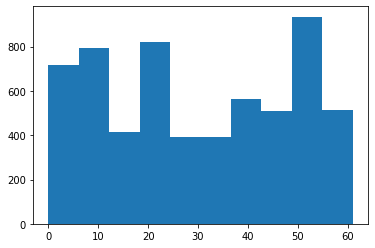

In [51]:
import pandas as pd
from pandas import read_excel
import matplotlib.pyplot as plt
data['Business Description'] = data['Business Description'].astype(str)
from sklearn.preprocessing import OrdinalEncoder
#ord_enc = OrdinalEncoder()
#data["x"] = ord_enc.fit_transform(data["Industry Classification Tag"])
#data=data.drop(['Industry Classification Tag','Company Name'], axis = 1)
plt.hist(data['x'])
train_text, test_text, train_y, test_y = train_test_split(data['Business Description'],data['x'],test_size = 0.2)
train_text.shape
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
sequences[0]

In [61]:
#dataset = GNN_Dataset_class(train_filename='/content/gdrive/MyDrive/intern_tasks/Text-Classification-using-GNN-main/Training_Data(1).xlsx',
#                                  test_filename='/content/gdrive/MyDrive/intern_tasks/Text-Classification-using-GNN-main/Training_Data(1).xlsx', tokenizer=tokenizer)
dataset = sequences

In [63]:
def pad_custom_sequence(sequences):
  node_sets_sequence = []
  neighbor_sets_sequence = []
  public_edge_mask_sequence = []
  label_sequence = []
  for node_sets, neighbor_sets, public_edge_mask, label in sequences:
    node_sets_sequence.append(node_sets)
    neighbor_sets_sequence.append(neighbor_sets)
    public_edge_mask_sequence.append(public_edge_mask)
    label_sequence.append(label)
  node_sets_sequence = torch.nn.utils.rnn.pad_sequence(node_sets_sequence, batch_first=True, padding_value=1)
  neighbor_sets_sequence, _ = padding_tensor(neighbor_sets_sequence)
  public_edge_mask_sequence, _ = padding_tensor(public_edge_mask_sequence)
  label_sequence = torch.nn.utils.rnn.pad_sequence(label_sequence, batch_first=True, padding_value=1)
  return node_sets_sequence, neighbor_sets_sequence, public_edge_mask_sequence, label_sequence

def pad_custom_for_test(sequences):
  node_sets_sequence = []
  neighbor_sets_sequence = []
  public_edge_mask_sequence = []
  for node_sets, neighbor_sets, public_edge_mask in sequences:
    node_sets_sequence.append(node_sets)
    neighbor_sets_sequence.append(neighbor_sets)
    public_edge_mask_sequence.append(public_edge_mask)
  node_sets_sequence = torch.nn.utils.rnn.pad_sequence(node_sets_sequence, batch_first=True, padding_value=1)
  neighbor_sets_sequence, _ = padding_tensor(neighbor_sets_sequence)
  public_edge_mask_sequence, _ = padding_tensor(public_edge_mask_sequence)
  return node_sets_sequence, neighbor_sets_sequence, public_edge_mask_sequence
  

def padding_tensor(sequences, padding_idx=1):
  num = len(sequences)
  max_len_0 = max([s.shape[0] for s in sequences])
  max_len_1 = max([s.shape[1] for s in sequences])
  out_dims = (num, max_len_0, max_len_1)
  out_tensor = sequences[0].data.new(*out_dims).fill_(padding_idx)
  for i, tensor in enumerate(sequences):
    len_0 = tensor.size(0)
    len_1 = tensor.size(1)
    out_tensor[i, :len_0, :len_1] = tensor
  mask = out_tensor == padding_idx
  return out_tensor, mask

In [68]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=pad_custom_sequence)
validation_loader = DataLoader(word_index, batch_size=32, shuffle=True, collate_fn=pad_custom_sequence)
test_loader = DataLoader(sequences_test, batch_size=32, collate_fn=pad_custom_for_test)

In [77]:
MAX_SEQUENCE_LENGTH = 160

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (4836, 160)
Shape of data test tensor: (1209, 160)


In [78]:
y_train = train_y
y_test = test_y

y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (4836, 62)


In [79]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model
EMBEDDING_DIM = 20
N_CLASSES = 62
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

# Text Level GNN

In [69]:
class MessagePassing(nn.Module):
  def __init__(self, vertice_count, input_size, out_size, dropout_rate=0, padding_idx=1):
    super(MessagePassing, self).__init__()
    self.vertice_count = vertice_count 
    self.input_size = input_size 
    self.out_size = out_size 
    self.dropout_rate = dropout_rate
    self.padding_idx = padding_idx
    self.information_rate = nn.Parameter(torch.rand(self.vertice_count, 1)) 
    self.linear = nn.Linear(self.input_size, self.out_size)
    self.dropout = nn.Dropout(self.dropout_rate)

  def forward(self, node_sets, embedded_node, edge_weight, embedded_neighbor_node):
    tmp_tensor = (edge_weight.view(-1, 1) * embedded_neighbor_node.view(-1, self.input_size)).view(embedded_neighbor_node.shape) 
    tmp_tensor = tmp_tensor.masked_fill(tmp_tensor == 0, -1e18) 
    tmp_tensor = self.dropout(tmp_tensor)
    M = tmp_tensor.max(dim=2)[0] 
    information_rate = self.information_rate[node_sets] 
    information_rate = information_rate.masked_fill((node_sets == self.padding_idx).unsqueeze(-1), 1) 
    embedded_node = (1 - information_rate) * M + information_rate * embedded_node 
    sum_embedded_node = embedded_node.sum(dim=1) 
    x = F.relu(self.linear(sum_embedded_node)) 
    #x = self.dropout(x)
    y = F.softmax(x, dim=1)
    return y

In [70]:
class TextLevelGNN(nn.Module):
  def __init__(self, pretrained_embeddings, out_size, dropout_rate=0, padding_idx=1):
    super(TextLevelGNN, self).__init__()
    self.out_size = out_size # c
    self.padding_idx = padding_idx
    self.weight_matrix = nn.Parameter(torch.randn(pretrained_embeddings.shape[0], pretrained_embeddings.shape[0])) 
    self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False, padding_idx=self.padding_idx) 
    self.message_passing = MessagePassing(vertice_count=pretrained_embeddings.shape[0], input_size=pretrained_embeddings.shape[1], out_size=self.out_size, dropout_rate=dropout_rate, padding_idx=self.padding_idx) 
    self.public_edge_weight = nn.Parameter(torch.randn(1, 1)) 

  def forward(self, node_sets, neighbor_sets, public_edge_mask):
    embedded_node = self.embedding(node_sets)
    edge_weight = model.weight_matrix[node_sets.unsqueeze(2).repeat(1, 1, neighbor_sets.shape[-1]), neighbor_sets] 
    a = edge_weight * ~public_edge_mask 
    b = self.public_edge_weight.unsqueeze(2).expand(1, public_edge_mask.shape[-2], public_edge_mask.shape[-1]) * public_edge_mask # (batch_size, max_sentence_length, max_neighbor_count)
    edge_weight = a + b 
    embedded_neighbor_node = self.embedding(neighbor_sets)

    # Apply mask to edge_weight, to mask and cut-off any relationships to the padding nodes
    edge_weight = edge_weight.masked_fill((node_sets.unsqueeze(2).repeat(1, 1, neighbor_sets.shape[-1]) == self.padding_idx) | (neighbor_sets == self.padding_idx), 0) # (batch_size, max_sentence_length, max_neighbor_count)
    x = self.message_passing(node_sets, embedded_node, edge_weight, embedded_neighbor_node) # (batch_size, c)
    return x

In [71]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# Optimization

In [82]:
model = TextLevelGNN(pretrained_embeddings=torch.tensor(embedded_sequences), out_size = 62,dropout_rate=0).to(device)
criterion = nn.BCELoss()

TypeError: ignored

In [73]:
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
ni = nf = 0

NameError: ignored

In [ ]:
"""
model_save_name = 'Tt_lvl_company description.pt'
path = F"/content/gdrive/My Drive/GNN Intern/saved_models/{model_save_name}"
model.load_state_dict(torch.load(path, map_location=device))
model.to(device)
"""

In [ ]:
ni += nf 
nf += 1
for epoch in range(ni,nf):
  model.train()
  train_loss = 0
  train_correct_items = 0
  previous_epoch_timestamp = time()

  if (epoch+1) % 5 == 0:
    if epoch: 
      lr *= 0.95
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

  train_preds = []
  validation_preds = []
  if epoch == 0:
    train_labels = []
    validation_labels = []
  for i, (node_sets, neighbor_sets, public_edge_masks, labels) in enumerate(train_loader):
    node_sets = node_sets.to(device)
    neighbor_sets = neighbor_sets.to(device)
    public_edge_masks = public_edge_masks.to(device)
    labels = labels.to(device)
    if epoch == 0: train_labels.append(labels.argmax(dim=1))
    prediction = model(node_sets, neighbor_sets, public_edge_masks)
    train_preds.append(prediction)
    loss = criterion(prediction, labels).to(device)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_correct_items += (prediction.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
  train_accuracy = train_correct_items / len(dataset.train_dataset)

  model.eval()
  validation_loss = 0
  validation_correct_items = 0
  for i, (node_sets, neighbor_sets, public_edge_masks, labels) in enumerate(validation_loader):
    node_sets = node_sets.to(device)
    neighbor_sets = neighbor_sets.to(device)
    public_edge_masks = public_edge_masks.to(device)
    labels = labels.to(device)
    if epoch == 0: validation_labels.append(labels.argmax(dim=1))
    prediction = model(node_sets, neighbor_sets, public_edge_masks)
    validation_preds.append(prediction)
    loss = criterion(prediction, labels).to(device)
    validation_loss += loss.item()
    validation_correct_items += (prediction.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
  validation_accuracy = validation_correct_items / len(dataset.validation_dataset)

  print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}, Time Used: {time()-previous_epoch_timestamp:.2f}s')


In [ ]:
model.eval()
test_preds = []
for i, (node_sets, neighbor_sets, public_edge_masks) in enumerate(test_loader):
  node_sets = node_sets.to(device)
  neighbor_sets = neighbor_sets.to(device)
  public_edge_masks = public_edge_masks.to(device)
  prediction = model(node_sets, neighbor_sets, public_edge_masks)
  test_preds.append(prediction)

# Saving all Train, Validation, labels and text predictions

In [ ]:
train_labels = [label.cpu().data.numpy() for label in train_labels]
train_labels = np.concatenate(train_labels)

validation_labels = [label.cpu().data.numpy() for label in validation_labels]
validation_labels = np.concatenate(validation_labels)

np.savez('/content/gdrive/MyDrive/intern_tasks/Text-Classification-using-GNN-main/labels.npz',train_labels = train_labels, validation_labels = validation_labels)
del train_labels, validation_labels

In [ ]:
train_preds = [pred.cpu().data.numpy() for pred in train_preds]
train_preds = np.vstack(train_preds)

validation_preds = [pred.cpu().data.numpy() for pred in validation_preds]
validation_preds = np.vstack(validation_preds)

test_preds = [i.cpu().data.numpy() for i in test_preds]
test_preds = np.vstack(test_preds)

np.savez('/content/gdrive/MyDrive/intern_tasks/Text-Classification-using-GNN-main/predictions.npz',train_preds = train_preds, validation_preds = validation_preds, test_preds = test_preds)
del train_preds, validation_preds, test_preds

# MRR, F1 and ROC_AUC Scores for Train and Validation

In [ ]:
labels = np.load('/content/gdrive/MyDrive/intern_tasks/Text-Classification-using-GNN-main/labels.npz')
preds = np.load('/content/gdrive/MyDrive/intern_tasks/Text-Classification-using-GNN-main/predictions.npz')

train_preds = preds['train_preds']
validation_preds = preds['validation_preds']

train_labels = labels['train_labels']
validation_labels = labels['validation_labels']

train_preds = train_preds.argmax(axis=1)
validation_preds = validation_preds.argmax(axis=1)

train_f1 = f1_score(train_labels,train_preds,average='weighted')
validation_f1 = f1_score(validation_labels,validation_preds,average='weighted')
print("F1_score of train_set: ",train_f1, " F1_score of validation_set: ",validation_f1)

#Mean Reciprocal Rank (MRR)
train_mrr = [np.array(arr).argsort()[::-1] for arr in preds["train_preds"]]
validation_mrr = [np.array(arr).argsort()[::-1] for arr in preds['validation_preds']]
t_mrr = np.mean([1/(1 + np.where(arr == i)[0].item()) for arr,i in zip(train_mrr,train_labels)])
v_mrr = np.mean([1/(1+np.where(arr == i)[0].item()) for arr,i in zip(validation_mrr,validation_labels)])
print("MRR of train_set: ",t_mrr," MRR of validation_set",v_mrr)

train_roc_ovr = roc_auc_score(train_labels,preds['train_preds'],multi_class='ovr',average='weighted')
train_roc_ovo = roc_auc_score(train_labels,preds['train_preds'],multi_class='ovo',average='weighted')
validation_roc_ovr = roc_auc_score(validation_labels,preds['validation_preds'],multi_class='ovr',average='weighted')
validation_roc_ovo = roc_auc_score(validation_labels,preds['validation_preds'],multi_class='ovo',average='weighted')
print("Area under ROC curve:\n\t one versus rest weighted average of AUC:")
print("\t AUC of train_set: ",train_roc_ovr, "AUC of validation_set: ",validation_roc_ovr)
print("\t one versus one weighted average of AUC: ")
print("\t AUC of train_set: ",train_roc_ovo, "AUC of validation_set: ",validation_roc_ovo)

# Output for Test data

In [ ]:
#upto 5 tags for each description
test_args = [np.array(arr).argsort()[::-1][:5] for arr in preds["test_preds"]]
data = pd.read_excel('/content/gdrive/MyDrive/intern_tasks/Text-Classification-using-GNN-main/Training_Data.xlsx')
data['First order tag'] = [classes[str(tags[0])] for tags in test_args]
data['Second order tag'] = [classes[str(tags[1])] for tags in test_args]
data['Third order tag'] = [classes[str(tags[2])] for tags in test_args]
data['Fourth order tag'] = [classes[str(tags[3])] for tags in test_args]
data['Fifth order tag'] = [classes[str(tags[4])] for tags in test_args]
data.to_csv('/content/gdrive/MyDrive/intern_tasks/Text-Classification-using-GNN-main/Output.csv',index=False)